In [2]:
import segmentation_models_pytorch as smp
import copy
import torch
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CyclicLR
from tqdm import tqdm, trange
from torchinfo import summary

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Устройство для обучения
device

device(type='cpu')

## Настройка параметров

In [57]:
LOAD_MODEL = False  # Пропустить обучение модели

# Директории с датасетами
TRAIN_PATH        = './fixed_train/'
TRAIN_LABELS_PATH = './fixed_train_labels/'

VAL_PATH        = './val'
VAL_LABELS_PATH = './val_labels/'

TEST_PATH        = './test'
TEST_LABELS_PATH = './test_labels./'


# Параметры загрузчиков
BACTH_SIZE = 16
NUM_WORKERS = os.cpu_count() if device.type == 'cuda' else 0
PIN_MEMORY = True if device.type == 'cuda' else False

# Среднее и стандартное отклонение тренировочного датасета
# None, если нужно рассчитать
MEAN = [0, 0, 0]
STD  = [1, 1, 1]

# Параметры оптимизатора
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
LEARNING_RATE = 5e-3

# Параметры планировщика
BASE_LR = LEARNING_RATE
MAX_LR = 0.1
STEP_SIZE_UP = 5
MODE = "triangular2"

# Параметры обучения
NUM_EPOCHS = 30

## Рассчет среднего и стандартного отклонения

In [58]:
if MEAN == None or STD == None:
    
    class Train_Dataset(Dataset):
         
        def __init__(self, images_dir):

            self.images_dir = images_dir
            self.images     = os.listdir(images_dir)
            self.transforms = A.Compose([
                                A.Normalize(mean = (0, 0, 0), std  = (1, 1, 1)),
                                ToTensorV2()])

        def __getitem__(self, idx):

            image = cv2.cvtColor(cv2.imread(os.path.join(self.images_dir, self.images[idx])), cv2.COLOR_BGR2RGB)

             # Перевод пикселей из [0, 255] в [0, 1]
            image = self.transforms(image = image)['image']
            
            return image
        
        def __len__(self):
            return len(self.images)

   
    dataset    = Train_Dataset(TRAIN_PATH)
    dataloader = DataLoader(dataset, batch_size = 64, shuffle = False)

    MEAN = torch.zeros(3)
    STD  = torch.zeros(3)

    cnt = 1500 ** 2 * len(dataset)

    for image in tqdm(dataloader):

        MEAN += image.sum(axis = (0, 2, 3))
        STD  += (image ** 2).sum(axis = (0, 2, 3))

    MEAN /= cnt
    STD   = torch.sqrt((STD / cnt) - (MEAN ** 2))

    print('Mean:', MEAN)
    print('Std:', STD)

## Настройка аугментаций

In [59]:
train_transform = A.Compose([
        A.RandomCrop(224, 224), 
        A.ToFloat(255, 255), 
        #A.Normalize(mean = MEAN, std = STD),
        A.RandomBrightnessContrast(brightness_limit = 0.1, p = 0.5),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.RandomRotate90(p = 0.5),
        A.RandomShadow(shadow_roi = (0, 0, 1, 1), num_shadows_upper = 10, p = 0.5),
        ToTensorV2()])

val_test_transform = A.Compose([
        #A.Normalize(mean = MEAN, std = STD),
        A.ToFloat(255, 255),
        A.PadIfNeeded(1504, 1504),  
        ToTensorV2()])

## Подготовка датасетов

In [60]:
class road_Dataset(Dataset):

    def __init__(self, images_dir, masks_dir, transforms = None):

        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.transforms = transforms
        self.images     = os.listdir(images_dir)

    def __getitem__(self, idx):

        image = cv2.cvtColor(cv2.imread(os.path.join(self.images_dir, self.images[idx])), cv2.COLOR_BGR2RGB)
        mask  = cv2.cvtColor(cv2.imread(os.path.join(self.masks_dir, self.images[idx].replace(".tiff", ".tif"))), cv2.COLOR_RGB2GRAY)

        mask[mask == 255] = 1

        if self.transforms:
            transformed = self.transforms(image = image, mask = mask)
            image = transformed['image']
            mask  = transformed['mask']
        
        # Применение one-hot encoding для маски
        # one_hot_mask    = np.zeros((2, mask.shape[0], mask.shape[1]))
        # one_hot_mask[0] = np.where(mask == 0, 1, 0)
        # one_hot_mask[1] = mask

        return image, mask[None, :, :]
    
    def __len__(self):
        return len(self.images)

In [61]:
# Создание датасетов
train_dataset = road_Dataset(TRAIN_PATH, TRAIN_LABELS_PATH, transforms = train_transform)
val_dataset   = road_Dataset(VAL_PATH, VAL_LABELS_PATH, transforms = val_test_transform)
test_dataset  = road_Dataset(TEST_PATH, TEST_LABELS_PATH, transforms = val_test_transform)

n_train = len(train_dataset) # Количество изображений в тренировочном датасете
n_val   = len(val_dataset)   # Количество изображений в валидационном датасете
n_test  = len(test_dataset)  # Количество изображений в тестовом датасете

## Создание загрузчиков 

In [62]:
train_loader = DataLoader(train_dataset, batch_size = BACTH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
val_loader   = DataLoader(val_dataset, batch_size = BACTH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size = BACTH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY)

## Вывод изображений с масками

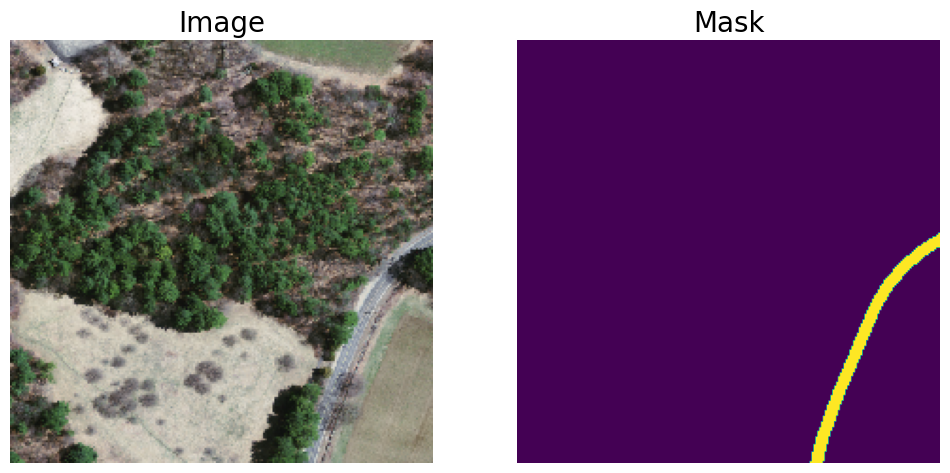

In [63]:
# Вывод заданного количества изображений
def imshow(images, targets, cnt, predicts = None):

    # Подготовка холста для изображений
    if predicts != None: 
        fig, axs = plt.subplots(cnt, 3) 
        fig.set_figwidth(18)

    else:
        fig, axs = plt.subplots(cnt, 2) 
        fig.set_figwidth(12)

    axs = axs.flatten()
    fig.set_figheight(cnt * 6)

    for i, (image, mask) in enumerate(zip(images[:cnt], targets[:cnt])):
    
        # Приведение массивов к формату (H, W, Ch)
        np_img  = image.numpy()
        np_mask = mask.numpy().squeeze()

        np_img = np.transpose(np_img, (1, 2, 0)).squeeze()

        # Вывод изображения
        axs[i * 2].imshow(np_img)
        axs[i * 2 + 1].imshow(np_mask)

        axs[i * 2].set_axis_off()
        axs[i * 2 + 1].set_axis_off()

        if predicts != None:
            np_predict = predicts[i][0].numpy()
            axs[i * 2 + 2].imshow(np_predict)
            axs[i * 2 + 2].set_axis_off()

        if i == 0:
            axs[0].set_title('Image', fontsize = 20)
            axs[1].set_title('Mask', fontsize = 20)

            if predicts != None:
                axs[2].set_title('Predicted Mask', fontsize = 20)
 
    plt.show()
   
# Получить случайные тренировочные изображения
dataiter = iter(train_loader)
images, targets = next(dataiter)

imshow(images, targets, 1)

## Создание модели

In [ ]:
model     = smp.Unet(encoder_name = 'resnet50', encoder_weights = 'imagenet', classes = 1).to(device)
criterion = smp.losses.SoftBCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
schedule  = CyclicLR(optimizer, base_lr = BASE_LR, max_lr = MAX_LR, step_size_up = STEP_SIZE_UP, mode = MODE, cycle_momentum = False)
scaler    = torch.cuda.amp.GradScaler()

params = smp.encoders.get_preprocessing_params('resnet50')

# Загрузить сохраненные веса в модель
if LOAD_MODEL:
    model.load_state_dict(torch.load('./weights.h5'))

## Обучение модели

In [ ]:
if not LOAD_MODEL:

    # Значения функции потерь в течение обучения
    train_losses = np.zeros(NUM_EPOCHS) 
    val_losses   = np.zeros(NUM_EPOCHS)

    # Значения IOU в течение обучения
    train_IOUs = np.zeros(NUM_EPOCHS) 
    val_IOUs   = np.zeros(NUM_EPOCHS)

    lrs = []
    
    for epoch in (pbar := trange(NUM_EPOCHS, position = 0)):
        
        best_weights = copy.deepcopy(model.state_dict())
        best_IOU = 0

        model.train()

        for images, targets in train_loader:  

            images  = images.to(device)
            targets = targets.float().to(device)
            
            with torch.cuda.amp.autocast():

                # Прямой проход
                predictions = model(images)
                loss = criterion(predictions, targets)           
                train_losses[epoch] += loss.item()

                predictions = predictions.sigmoid()
                predictions = (predictions > 0.5).float()

                tp, fp, fn, tn = smp.metrics.get_stats(predictions.long(), targets.long(), mode = 'binary')
                train_IOUs[epoch] += sum(smp.metrics.iou_score(tp, fp, fn, tn))

            # Обратный проход
            optimizer.zero_grad()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            lrs.append(optimizer.param_groups[0]["lr"])
            
        schedule.step()
        train_IOUs[epoch]    = 100 * train_IOUs[epoch] / len(train_loader)
        train_losses[epoch] /= len(train_loader)

        # Валидация
        with torch.no_grad():

            model.eval()

            for images, targets in val_loader:

                images  = images.to(device)
                targets = targets.float().to(device)

                # Прямой проход
                predictions = model(images)      
                loss = criterion(predictions, targets)
                val_losses[epoch] += loss.item()

                predictions = predictions.sigmoid()
                predictions = (predictions > 0.5).float()

                tp, fp, fn, tn = smp.metrics.get_stats(predictions.long(), targets.long(), mode = 'binary')
                val_IOUs[epoch] += sum(smp.metrics.iou_score(tp, fp, fn, tn))

            val_IOUs[epoch]    = 100 * val_IOUs[epoch] / len(val_loader)
            val_losses[epoch] /= len(val_loader)

            # Сохранение весов, если результат на текущей эпохе лучше
            if best_IOU < val_IOUs[epoch]:
                best_IOU = val_IOUs[epoch]
                best_weights = copy.deepcopy(model.state_dict())

        pbar.set_description(f'Avg. train/valid loss: [{train_losses[epoch].item():.2f}/{val_losses[epoch].item():.2f}], train/valid IOU: [{train_IOUs[epoch]:.2f}%/{val_IOUs[epoch]:.2f}%]')

    # Загрузка и сохранение лучших весов
    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), './weights.h5')


Avg. train/valid loss: [0.69/0.69], train/valid IOU: [20.51%/7.14%]:  23%|██▎       | 7/30 [02:37<08:34, 22.35s/it] 

## Графики

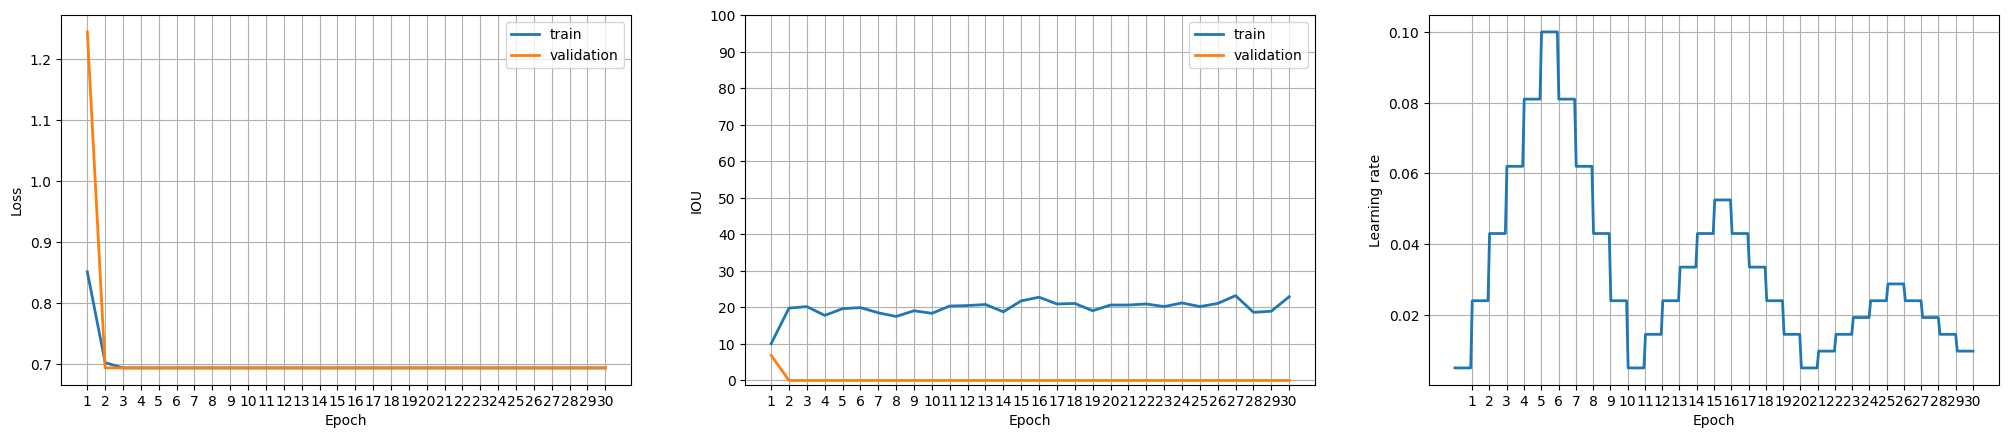

In [ ]:
if not LOAD_MODEL:
    
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25) 

    axs[0].plot(range(1, NUM_EPOCHS + 1), train_losses, linewidth = 2, label = 'train')
    axs[0].plot(range(1, NUM_EPOCHS + 1), val_losses, linewidth = 2, label = 'validation')
    axs[0].set_xticks(range(1, NUM_EPOCHS + 1))
    axs[0].set_xlabel('Epoch') 
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(range(1, NUM_EPOCHS + 1), train_IOUs, linewidth = 2, label = 'train')
    axs[1].plot(range(1, NUM_EPOCHS + 1), val_IOUs, linewidth = 2, label = 'validation')
    axs[1].set_xticks(range(1, NUM_EPOCHS + 1))
    axs[1].set_yticks(range(0, 101, 10))
    axs[1].set_xlabel('Epoch') 
    axs[1].set_ylabel('IOU')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(np.linspace(0, NUM_EPOCHS, len(lrs)), lrs, linewidth = 2)
    axs[2].set_xticks(range(1, NUM_EPOCHS + 1))
    axs[2].set_xlabel('Epoch') 
    axs[2].set_ylabel('Learning rate')
    axs[2].grid()

    plt.show()

## Тестирование модели

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


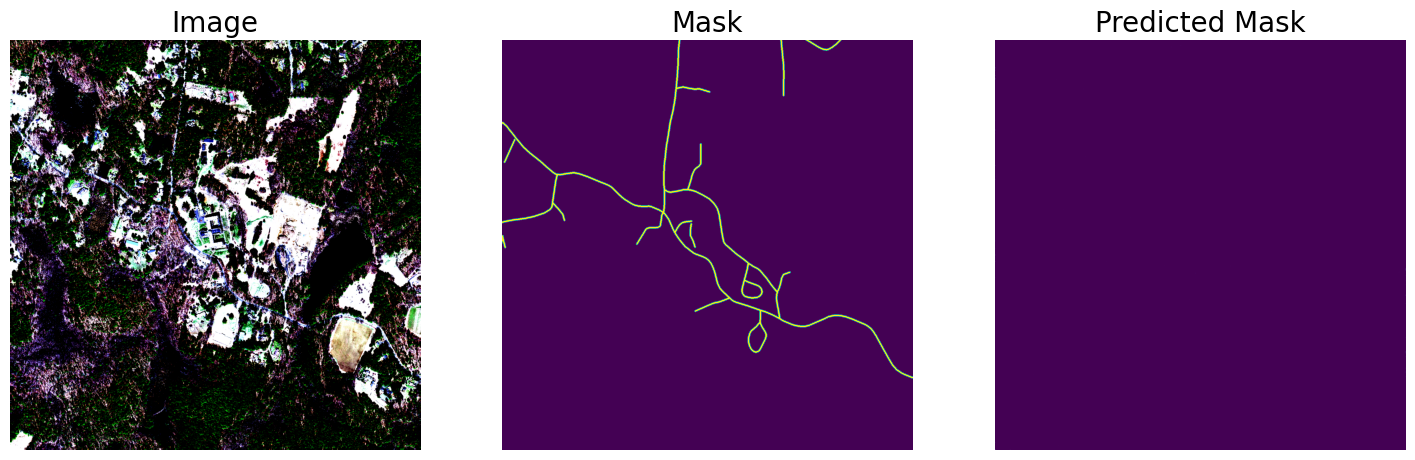

IOU-score of the network on the 49 testing images: 0.0000 %


In [ ]:
IOU = 0

model.eval()

with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        
        images  = images.to(device)
        targets = targets.float().to(device)

        # Прямой проход
        predictions = model(images)
            
        tp, fp, fn, tn = smp.metrics.get_stats(predictions, targets, mode = 'binary', threshold = 0.5)
        IOU += sum(smp.metrics.iou_score(tp, fp, fn, tn))
        
        # Отобразить изображения с предсказанными названиями
        if not i:
            imshow(images.cpu(), targets.cpu(), 1, predictions.cpu())
     
    print('IOU-score of the network on the {} testing images: {:.4f} %'.format(n_test, 100 * IOU.item() / len(test_loader)))